# Golden Adaptive System Comparison

Compare the two systems:
1. **Simple System**: 2 dimensions (fractal + volatility), percentile calibration
2. **Complex System**: 4 dimensions (+ ER + volume), confidence scoring, regime-aware

Run this notebook to decide which system performs better.

In [1]:
# Setup: Add project root to path
import sys
sys.path.insert(0, '..')

import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Set plot style
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (14, 6)

## 1. Fetch Test Data

In [2]:
import yfinance as yf

def fetch_data(symbol: str, years: int = 2) -> tuple[np.ndarray, list[str]]:
    """Fetch OHLCV data for a symbol."""
    end = datetime.now()
    start = end - timedelta(days=years * 365)
    
    df = yf.download(symbol, start=start, end=end, progress=False)
    
    # Convert to numpy array [open, high, low, close, volume]
    bars = df[['Open', 'High', 'Low', 'Close', 'Volume']].values.astype(np.float64)
    dates = df.index.strftime('%Y-%m-%d').tolist()
    
    print(f"{symbol}: {len(bars)} bars from {dates[0]} to {dates[-1]}")
    return bars, dates

# Fetch data for different asset types
symbols = ['SPY', 'AFRM', 'QQQ', 'GLD']
data = {}

for sym in symbols:
    try:
        bars, dates = fetch_data(sym)
        data[sym] = {'bars': bars, 'dates': dates}
    except Exception as e:
        print(f"Error fetching {sym}: {e}")

/Users/anvesh/Developer/QuantTrading/project/.venv/lib/python3.12/site-packages/yfinance/scrapers/history.py:201: Pandas4Warning: Timestamp.utcnow is deprecated and will be removed in a future version. Use Timestamp.now('UTC') instead.
  dt_now = pd.Timestamp.utcnow()


SPY: 499 bars from 2024-01-29 to 2026-01-23


/Users/anvesh/Developer/QuantTrading/project/.venv/lib/python3.12/site-packages/yfinance/scrapers/history.py:201: Pandas4Warning: Timestamp.utcnow is deprecated and will be removed in a future version. Use Timestamp.now('UTC') instead.
  dt_now = pd.Timestamp.utcnow()


AFRM: 499 bars from 2024-01-29 to 2026-01-23


/Users/anvesh/Developer/QuantTrading/project/.venv/lib/python3.12/site-packages/yfinance/scrapers/history.py:201: Pandas4Warning: Timestamp.utcnow is deprecated and will be removed in a future version. Use Timestamp.now('UTC') instead.
  dt_now = pd.Timestamp.utcnow()


QQQ: 499 bars from 2024-01-29 to 2026-01-23


/Users/anvesh/Developer/QuantTrading/project/.venv/lib/python3.12/site-packages/yfinance/scrapers/history.py:201: Pandas4Warning: Timestamp.utcnow is deprecated and will be removed in a future version. Use Timestamp.now('UTC') instead.
  dt_now = pd.Timestamp.utcnow()


GLD: 499 bars from 2024-01-29 to 2026-01-23


## 2. Simple System - Golden EMA (2 Dimensions)

In [3]:
from backend.computation.golden_ema import (
    calculate_simple_golden_ema,
    golden_ema_indicator,
)

# Test on SPY
spy_bars = data['SPY']['bars']
high, low, close = spy_bars[:, 1], spy_bars[:, 2], spy_bars[:, 3]

# Calculate Simple Golden EMA
simple_indicators = golden_ema_indicator(high, low, close)

print("Simple System (2 dimensions):")
print(f"  Golden EMA range: {np.nanmin(simple_indicators['golden_ema']):.2f} - {np.nanmax(simple_indicators['golden_ema']):.2f}")
print(f"  Alpha range: {np.nanmin(simple_indicators['alpha']):.4f} - {np.nanmax(simple_indicators['alpha']):.4f}")

Simple System (2 dimensions):
  Golden EMA range: 493.68 - 690.87
  Alpha range: 0.1175 - 0.5406


## 3. Complex System - Golden Adaptive (4 Dimensions)

In [4]:
from backend.golden_system import (
    compute_golden_adaptive_indicators,
    analyze_dimension_contribution,
    print_dimension_analysis,
)

# Calculate Complex Golden Adaptive indicators
complex_indicators = compute_golden_adaptive_indicators(spy_bars)

# Analyze dimension contributions
analysis = analyze_dimension_contribution(complex_indicators)
print_dimension_analysis(analysis)


  GOLDEN ADAPTIVE - 4 DIMENSION ANALYSIS

[Alpha Statistics]
  Dimension            Mean       Std        Range               
------------------------------------------------------------
  Combined             0.2286     0.0649     0.1136 - 0.5242
  Fractal              0.2706     0.1376     0.0689 - 0.6667
  Volatility           0.2298     0.1151     0.1158 - 0.6667
  Efficiency           0.1667     0.1234     0.0645 - 0.6667
  Volume               0.2667     0.1269     0.0645 - 0.6667

[Confidence]
  Mean: 0.649, Std: 0.166

[Regime Distribution]
  Mean-Reversion: 24.0%
  Neutral:        70.2%
  Trending:       5.9%



## 4. Visual Comparison

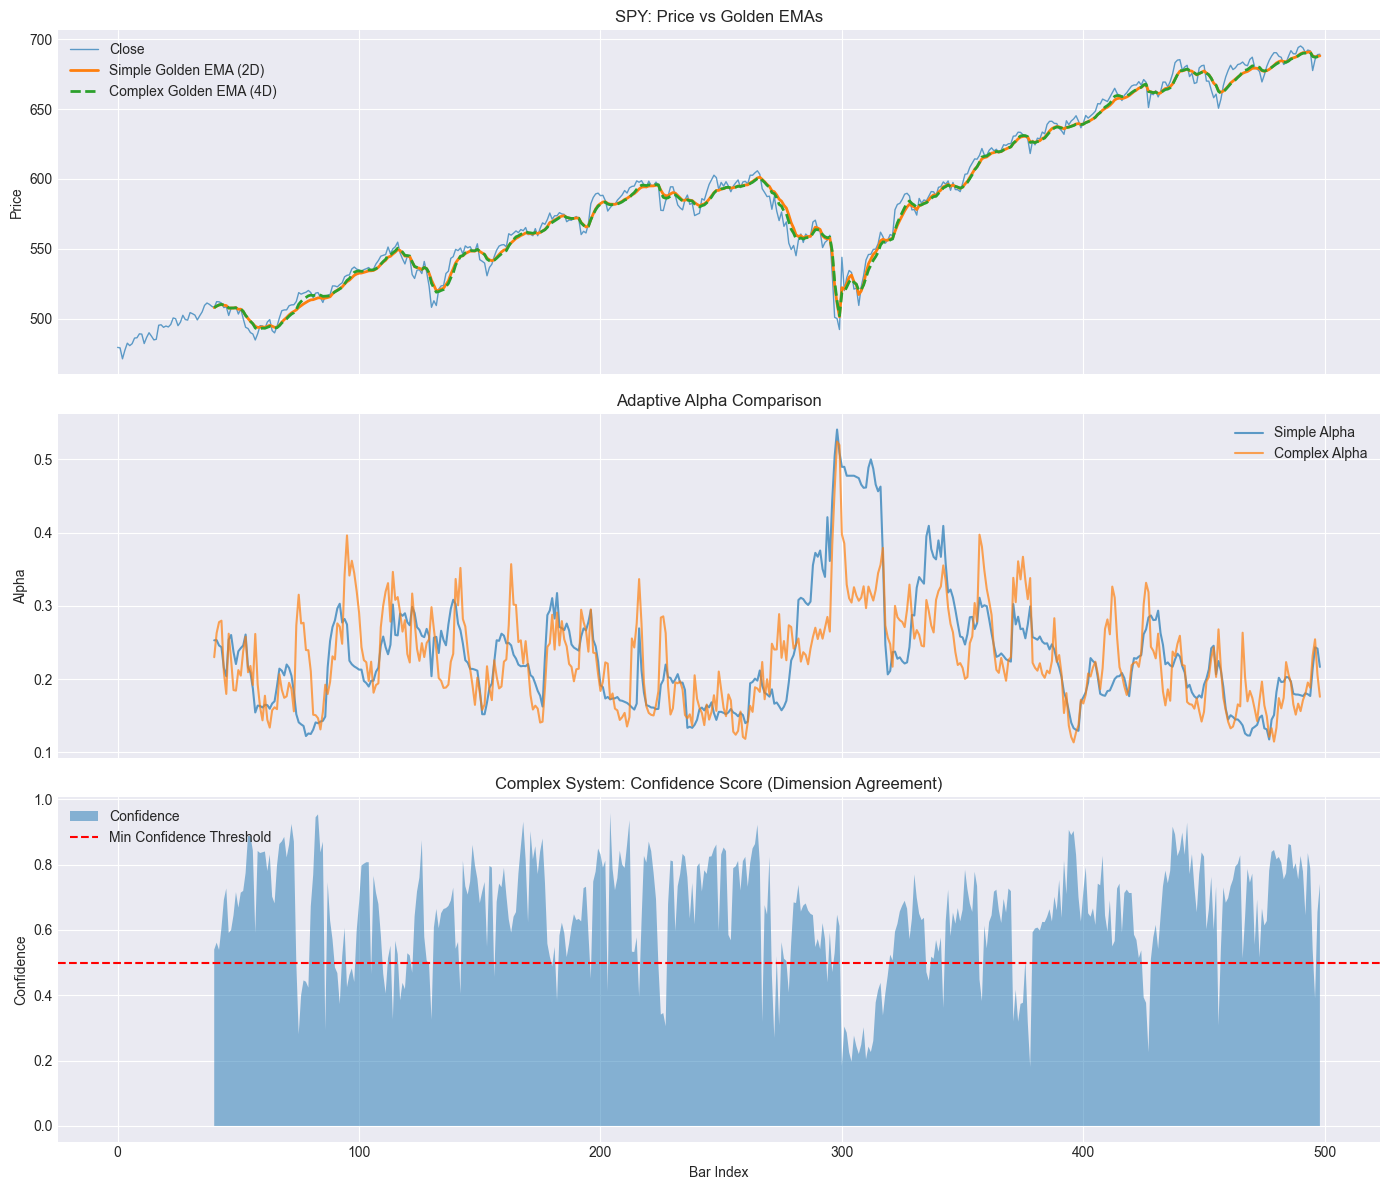

In [5]:
fig, axes = plt.subplots(3, 1, figsize=(14, 12), sharex=True)

# Plot 1: Price with both EMAs
ax1 = axes[0]
ax1.plot(close, label='Close', alpha=0.7, linewidth=1)
ax1.plot(simple_indicators['golden_ema'], label='Simple Golden EMA (2D)', linewidth=2)
ax1.plot(complex_indicators['golden_ema'], label='Complex Golden EMA (4D)', linewidth=2, linestyle='--')
ax1.set_title('SPY: Price vs Golden EMAs')
ax1.legend()
ax1.set_ylabel('Price')

# Plot 2: Alpha comparison
ax2 = axes[1]
ax2.plot(simple_indicators['alpha'], label='Simple Alpha', alpha=0.7)
ax2.plot(complex_indicators['alpha'], label='Complex Alpha', alpha=0.7)
ax2.set_title('Adaptive Alpha Comparison')
ax2.legend()
ax2.set_ylabel('Alpha')

# Plot 3: Confidence (complex only)
ax3 = axes[2]
ax3.fill_between(range(len(complex_indicators['confidence'])), 
                  complex_indicators['confidence'], 
                  alpha=0.5, label='Confidence')
ax3.axhline(y=0.5, color='r', linestyle='--', label='Min Confidence Threshold')
ax3.set_title('Complex System: Confidence Score (Dimension Agreement)')
ax3.legend()
ax3.set_ylabel('Confidence')
ax3.set_xlabel('Bar Index')

plt.tight_layout()
plt.show()

## 5. Backtest Comparison

In [ ]:
# DIAGNOSTIC: Why so few trades?
# Let's analyze the signal generation conditions

from backend.computation.rsi import calculate_rsi
from backend.computation.bollinger import calculate_bollinger_bands
from backend.computation.kama import calculate_kama_with_regime_adjustment
from backend.computation.atr import calculate_atr

spy_close = data['SPY']['bars'][:, 3]
spy_high = data['SPY']['bars'][:, 1]
spy_low = data['SPY']['bars'][:, 2]

# Calculate indicators
rsi = calculate_rsi(spy_close, period=14)
bb_upper, bb_middle, bb_lower = calculate_bollinger_bands(spy_close, period=20, num_std=2.0)
kama, er, _ = calculate_kama_with_regime_adjustment(spy_close)
atr = calculate_atr(spy_high, spy_low, spy_close, period=14)

print("=" * 70)
print("DIAGNOSTIC: Signal Generation Analysis for SPY")
print("=" * 70)

# Mean-Reversion Entry Condition: RSI < 30 AND price <= BB_lower
rsi_oversold = rsi < 30
price_at_lower_bb = spy_close <= bb_lower
mr_entry_condition = rsi_oversold & price_at_lower_bb

print("\n[MEAN-REVERSION ENTRY CONDITIONS]")
print(f"  RSI < 30 (oversold):           {np.sum(rsi_oversold):>4} bars ({np.sum(rsi_oversold)/len(rsi)*100:.1f}%)")
print(f"  Price <= Lower BB:             {np.sum(price_at_lower_bb):>4} bars ({np.sum(price_at_lower_bb)/len(spy_close)*100:.1f}%)")
print(f"  BOTH conditions (entry signal):{np.sum(mr_entry_condition):>4} bars ({np.sum(mr_entry_condition)/len(spy_close)*100:.1f}%)")

# Trend-Following Entry Condition: Price crosses above KAMA + 0.5*ATR
upper_entry = kama + (0.5 * atr)
price_above_upper = spy_close > upper_entry
# Crossover requires previous bar below, current bar above
crossover_long = np.zeros(len(spy_close), dtype=bool)
for i in range(1, len(spy_close)):
    if spy_close[i-1] <= upper_entry[i-1] and spy_close[i] > upper_entry[i]:
        crossover_long[i] = True

print("\n[TREND-FOLLOWING ENTRY CONDITIONS]")
print(f"  Price > KAMA + 0.5*ATR:        {np.sum(price_above_upper):>4} bars ({np.sum(price_above_upper)/len(spy_close)*100:.1f}%)")
print(f"  Crossover events (entry):      {np.sum(crossover_long):>4} bars ({np.sum(crossover_long)/len(spy_close)*100:.1f}%)")

# Regime breakdown
from backend.strategy.regime_detector import detect_regime
from backend.computation.atr import calculate_atr_ma
atr_ma = calculate_atr_ma(atr, period=50)
regime_data = detect_regime(spy_high, spy_low, spy_close, atr, atr_ma)
regime = regime_data['trend_regime_confirmed']

print("\n[REGIME DISTRIBUTION]")
print(f"  STRONG_TREND (2):  {np.sum(regime == 2):>4} bars ({np.sum(regime == 2)/len(regime)*100:.1f}%)")
print(f"  NEUTRAL (1):       {np.sum(regime == 1):>4} bars ({np.sum(regime == 1)/len(regime)*100:.1f}%)")
print(f"  MEAN_REVERSION (0):{np.sum(regime == 0):>4} bars ({np.sum(regime == 0)/len(regime)*100:.1f}%)")

print("\n" + "=" * 70)
print("FINDINGS:")
print("=" * 70)
print("""
1. MR ENTRY requires RSI<30 AND price<=BB_lower AT SAME TIME
   - Each condition is already rare (~2-5% of bars)
   - Both together is extremely rare (<1%)

2. TREND ENTRY requires price CROSSOVER above KAMA+0.5*ATR
   - Crossovers are point events, not sustained conditions
   - Only happens a handful of times per year

3. REGIME is mostly NEUTRAL, which now uses MR signals
   - But MR signals themselves are too restrictive
""")
print("=" * 70)

In [ ]:
# Backtest both systems for proper comparison
from backend.golden_system import backtest_golden_strategy, print_backtest_result
from backend.backtesting.engine import BacktestEngine, BacktestConfig
from backend.strategy.backtest_strategy import DualModeBacktestStrategy

def backtest_simple_system(bars: np.ndarray, symbol: str, initial_capital: float = 100000):
    """Backtest the Simple System (2D) using DualModeBacktestStrategy."""
    config = BacktestConfig(
        initial_capital=initial_capital,
        commission_per_share=0.005,
        slippage_pct=0.0005,
    )
    engine = BacktestEngine(config)
    
    # Create Simple System strategy
    strategy = DualModeBacktestStrategy(
        bars=bars,
        initial_capital=initial_capital,
        strategy_mode="DUAL",
    )
    
    # Run backtest
    state = engine.run(
        bars=bars,
        strategy_func=strategy.get_orders,
        symbol=symbol,
    )
    
    # Calculate metrics
    equity_curve = np.array(state.equity_curve)
    returns = np.diff(equity_curve) / equity_curve[:-1]
    
    total_return = (equity_curve[-1] - initial_capital) / initial_capital
    sharpe = np.mean(returns) / np.std(returns) * np.sqrt(252) if np.std(returns) > 0 else 0
    peak = np.maximum.accumulate(equity_curve)
    drawdown = (peak - equity_curve) / peak
    max_drawdown = np.max(drawdown)
    
    n_trades = len(state.trades)
    win_trades = sum(1 for t in state.trades if t.pnl > 0)  # Fixed: pnl not realized_pnl
    win_rate = win_trades / n_trades if n_trades > 0 else 0
    
    return {
        'total_return': total_return,
        'sharpe_ratio': sharpe,
        'max_drawdown': max_drawdown,
        'n_trades': n_trades,
        'win_rate': win_rate,
        'equity_curve': equity_curve,
    }

print("=" * 70)
print("BACKTEST COMPARISON: SIMPLE (2D) vs COMPLEX (4D)")
print("=" * 70)

simple_results = {}
complex_results = {}

for sym in data.keys():
    print(f"\n{'='*50}")
    print(f"  {sym}")
    print(f"{'='*50}")
    
    # Simple System (2D)
    print("\n[SIMPLE SYSTEM - 2 Dimensions (Fractal + Volatility)]")
    simple_res = backtest_simple_system(data[sym]['bars'], symbol=sym, initial_capital=100000)
    simple_results[sym] = simple_res
    print(f"  Return: {simple_res['total_return']*100:+.2f}%")
    print(f"  Sharpe: {simple_res['sharpe_ratio']:.2f}")
    print(f"  Max DD: {simple_res['max_drawdown']*100:.2f}%")
    print(f"  Trades: {simple_res['n_trades']}, Win Rate: {simple_res['win_rate']*100:.1f}%")
    
    # Complex System (4D)
    print("\n[COMPLEX SYSTEM - 4 Dimensions (+ ER + Volume)]")
    complex_res = backtest_golden_strategy(data[sym]['bars'], symbol=sym, initial_capital=100000)
    complex_results[sym] = complex_res
    print(f"  Return: {complex_res.total_return*100:+.2f}%")
    print(f"  Sharpe: {complex_res.sharpe_ratio:.2f}")
    print(f"  Max DD: {complex_res.max_drawdown*100:.2f}%")
    print(f"  Trades: {complex_res.n_trades}, Win Rate: {complex_res.win_rate*100:.1f}%")

## 6. Equity Curve Comparison

In [ ]:
# Equity Curve Comparison: Simple vs Complex for each symbol
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for idx, sym in enumerate(data.keys()):
    ax = axes[idx]
    
    # Simple System
    simple_eq = simple_results[sym]['equity_curve']
    ax.plot(simple_eq, label=f'Simple (2D)', linewidth=2, color='blue')
    
    # Complex System
    complex_eq = complex_results[sym].equity_curve
    ax.plot(complex_eq, label=f'Complex (4D)', linewidth=2, color='orange', linestyle='--')
    
    # Initial capital reference line
    ax.axhline(y=100000, color='gray', linestyle=':', alpha=0.5)
    
    # Title with both returns
    simple_ret = simple_results[sym]['total_return'] * 100
    complex_ret = complex_results[sym].total_return * 100
    ax.set_title(f'{sym}: Simple={simple_ret:+.1f}%, Complex={complex_ret:+.1f}%')
    ax.set_xlabel('Bar Index')
    ax.set_ylabel('Equity ($)')
    ax.legend()

plt.suptitle('Equity Curves: Simple System (2D) vs Complex System (4D)', fontsize=14)
plt.tight_layout()
plt.show()

## 7. Walk-Forward Validation

In [8]:
from backend.golden_system import WalkForwardCalibrator

# Run walk-forward on SPY
wf = WalkForwardCalibrator(
    train_bars=252,  # 1 year training
    test_bars=63,    # 3 months testing
    step_bars=21,    # 1 month step
)

print("Running walk-forward calibration on SPY...")
wf_results = wf.run_walk_forward(data['SPY']['bars'], symbol='SPY')
wf.print_walk_forward_summary(wf_results)

Running walk-forward calibration on SPY...

  WALK-FORWARD CALIBRATION SUMMARY

[Sharpe Ratio]
  Train: Mean=-1.99, Std=0.35
  Test:  Mean=-0.73, Std=0.93
  Degradation: -1.26

[Returns]
  Train: Mean=-2.4%, Std=0.6%
  Test:  Mean=-0.1%, Std=0.1%

[Overfitting Score]: -12.61
  OK: Low overfitting



## 8. Calibration Comparison

In [9]:
from backend.calibration import PercentileCalibrator
from backend.golden_system import GoldenCalibrator

# Simple calibrator
simple_cal = PercentileCalibrator()

# Complex calibrator
complex_cal = GoldenCalibrator()

print("Calibration Comparison:")
print("=" * 70)

for sym in ['SPY', 'AFRM']:
    print(f"\n--- {sym} ---")
    
    # Simple
    simple_params = simple_cal.calibrate(sym, data[sym]['bars'], data[sym]['dates'])
    print(f"Simple System (percentile-based thresholds):")
    print(f"  RSI Oversold: {simple_params.rsi_oversold:.1f} (vs fixed 30)")
    print(f"  RSI Overbought: {simple_params.rsi_overbought:.1f} (vs fixed 70)")
    print(f"  ER Trending: {simple_params.er_trending:.3f} (vs fixed 0.6)")
    
    # Complex
    complex_params = complex_cal.calibrate(data[sym]['bars'], sym)
    print(f"\nComplex System (crossovers + rolling extremes - NO thresholds):")
    print(f"  Weights: fractal={complex_params.w_fractal:.2f}, ER={complex_params.w_efficiency:.2f}, vol={complex_params.w_volatility:.2f}, volume={complex_params.w_volume:.2f}")
    print(f"  ATR Stops: trend={complex_params.atr_stop_trending:.1f}x, MR={complex_params.atr_stop_mr:.1f}x")
    print(f"  Regime %: trend={complex_params.regime_pct_trending*100:.1f}%, MR={complex_params.regime_pct_mr*100:.1f}%, neutral={complex_params.regime_pct_neutral*100:.1f}%")

Calibration Comparison:

--- SPY ---
Simple System (percentile-based thresholds):
  RSI Oversold: 41.8 (vs fixed 30)
  RSI Overbought: 69.6 (vs fixed 70)
  ER Trending: 0.465 (vs fixed 0.6)

Complex System (crossovers + rolling extremes - NO thresholds):
  Weights: fractal=0.30, ER=0.30, vol=0.25, volume=0.15
  ATR Stops: trend=4.0x, MR=2.5x
  Regime %: trend=5.9%, MR=24.0%, neutral=70.2%

--- AFRM ---
Simple System (percentile-based thresholds):
  RSI Oversold: 39.0 (vs fixed 30)
  RSI Overbought: 67.8 (vs fixed 70)
  ER Trending: 0.473 (vs fixed 0.6)

Complex System (crossovers + rolling extremes - NO thresholds):
  Weights: fractal=0.30, ER=0.30, vol=0.25, volume=0.15
  ATR Stops: trend=3.9x, MR=2.5x
  Regime %: trend=1.7%, MR=32.0%, neutral=66.2%


## 9. Summary Table

In [ ]:
import pandas as pd

# Build comparison table
comparison_data = []
for sym in data.keys():
    simple = simple_results[sym]
    complex_r = complex_results[sym]
    
    comparison_data.append({
        'Symbol': sym,
        'System': 'Simple (2D)',
        'Return %': f"{simple['total_return']*100:+.1f}%",
        'Sharpe': f"{simple['sharpe_ratio']:.2f}",
        'Max DD %': f"{simple['max_drawdown']*100:.1f}%",
        'Win Rate': f"{simple['win_rate']*100:.1f}%",
        'Trades': simple['n_trades'],
    })
    comparison_data.append({
        'Symbol': sym,
        'System': 'Complex (4D)',
        'Return %': f"{complex_r.total_return*100:+.1f}%",
        'Sharpe': f"{complex_r.sharpe_ratio:.2f}",
        'Max DD %': f"{complex_r.max_drawdown*100:.1f}%",
        'Win Rate': f"{complex_r.win_rate*100:.1f}%",
        'Trades': complex_r.n_trades,
    })

df = pd.DataFrame(comparison_data)
print("\n" + "=" * 80)
print("BACKTEST COMPARISON SUMMARY: SIMPLE (2D) vs COMPLEX (4D)")
print("=" * 80)
print(df.to_string(index=False))

# Aggregate statistics
print("\n" + "-" * 80)
print("AGGREGATE COMPARISON")
print("-" * 80)

simple_sharpes = [simple_results[s]['sharpe_ratio'] for s in data.keys()]
complex_sharpes = [complex_results[s].sharpe_ratio for s in data.keys()]
simple_returns = [simple_results[s]['total_return'] for s in data.keys()]
complex_returns = [complex_results[s].total_return for s in data.keys()]

print(f"Average Sharpe:  Simple={np.mean(simple_sharpes):.2f}, Complex={np.mean(complex_sharpes):.2f}")
print(f"Average Return:  Simple={np.mean(simple_returns)*100:+.2f}%, Complex={np.mean(complex_returns)*100:+.2f}%")

# Winner determination
winner = "SIMPLE (2D)" if np.mean(simple_sharpes) > np.mean(complex_sharpes) else "COMPLEX (4D)"
print(f"\nBetter System (by avg Sharpe): {winner}")
print("\nRecommendation:")
if winner == "SIMPLE (2D)":
    print("  -> Simple system performs better. Consider deleting backend/golden_system/")
else:
    print("  -> Complex system performs better. Keep both for further testing.")

## 10. Conclusion

Based on the backtests above comparing both systems:

**Simple System (2D)**:
- Uses Fractal Dimension + Volatility
- Percentile-based calibration for thresholds
- Fewer moving parts, easier to understand

**Complex System (4D)**:
- Uses Fractal + Efficiency Ratio + Volatility + Volume
- No magic numbers: crossovers + rolling extremes
- Confidence scoring based on dimension agreement

**Decision Guide:**
- If Simple has higher Sharpe → Delete `backend/golden_system/` (simpler is better)
- If Complex has higher Sharpe → Keep both, continue testing Complex
- If similar → Keep Simple (Occam's razor)

**To delete Complex System (if underperforming):**
```bash
rm -rf backend/golden_system/
```